<a href="https://colab.research.google.com/github/AliARajabi/deep-learning/blob/main/CNN/Art_Generation_with_Neural_Style_Transfer(VGG19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from tensorflow.keras.applications.vgg19 import  VGG19,preprocess_input

#Using keras.backend.function
This methode need to convert numpy.ndarray to tensor that does not work in tape

In [ ]:
stm=VGG19(include_top=True,weights='imagenet')

KeyboardInterrupt: ignored

In [ ]:
stm.summary()

In [ ]:
!wget https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet_800600.jpg

In [ ]:
from PIL import Image
import numpy as np
from skimage import io

def load_img(path):
  return  io.imread(path)


In [ ]:
class CONFIG:
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
!wget https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre.jpg

In [ ]:
content_image = load_img("/content/louvre.jpg")
img=plt.imshow(content_image)
plt.axis('off')
img.set_cmap('hot')

In [ ]:
import tensorflow as tf


def compute_content_cost(a_C, a_G):
  m, n_H, n_W, n_C = a_G.shape
  new_shape=[int(m),int(n_H*n_W),int(n_C)]
  new_a_C=tf.reshape(a_C,new_shape)
  new_a_G=tf.reshape(a_G,new_shape)
  J_content=(.25 / float(int(n_H * n_W * n_C))) * tf.reduce_sum(np.power(new_a_G - new_a_C, 2))
  return J_content


In [ ]:
style_image = load_img("/content/monet_800600.jpg")
img=plt.imshow(style_image)
plt.axis('off')
img.set_cmap('hot')

In [ ]:
def gram_matrix(A):
  return tf.matmul(A,A,transpose_b=True)

In [ ]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape()
    
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])
    a_G = tf.transpose(a_G)
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    factor = (.5 / (n_H * n_W * n_C)) ** 2
    J_style_layer = factor * tf.reduce_sum(np.power(GS - GG, 2))
    return J_style_layer

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [ ]:
def get_output_layer(model, name):
  return model.get_layer(name).output

In [ ]:
first_conv_layer = get_output_layer(stm, 'block1_conv1')
second_conv_layer = get_output_layer(stm, 'block2_conv1')
third_conv_layer = get_output_layer(stm, 'block3_conv1')
fourth_conv_layer = get_output_layer(stm, 'block4_conv1')
fifth_conv_layer = get_output_layer(stm, 'block5_conv1')


In [ ]:
from keras import backend as K

get_layers_output = K.function([stm.layers[0].input],
                                  [first_conv_layer ,second_conv_layer ,third_conv_layer ,fourth_conv_layer ,fifth_conv_layer])
#layer_output = get_layers_output([test])

In [ ]:
print(type(layer_output[4]))
print(layer_output[4].shape)

In [ ]:
layers_output3=[get_output_layer(stm, name) for name,_ in STYLE_LAYERS]
get_layers_output3=K.function([stm.layers[0].input],layers_output3)
a_S_layer_output = get_layers_output3([PRstyle_image])
def compute_style_cost(model,a_S_layer_output,generated_image):
  a_G_layer_output = get_layers_output3([generated_image])
  count=0
  J_style = 0
  for _, coeff in STYLE_LAYERS:
    a_S = tf.convert_to_tensor(a_S_layer_output[count], dtype=tf.float32)
    a_G = tf.convert_to_tensor(a_G_layer_output[count], dtype=tf.float32)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    J_style += coeff * J_style_layer
    count +=1

  return J_style

In [ ]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style    
    return J

In [ ]:
import cv2 as cv
Rcontent_image=cv.resize(content_image,(224,224), interpolation = cv.INTER_AREA)
print(Rcontent_image.shape)
Rcontent_image=np.expand_dims(Rcontent_image,axis=0)
print(Rcontent_image.shape)

In [ ]:
Rstyle_image=cv.resize(style_image,(224,224), interpolation = cv.INTER_AREA)
print(Rstyle_image.shape)
Rstyle_image=np.expand_dims(Rstyle_image,axis=0)
print(Rstyle_image.shape)

In [ ]:
def load_resize_image(path):
  temp=cv.imread(path)
  temp=cv.resize(temp,(CONFIG.IMAGE_HEIGHT,CONFIG.IMAGE_WIDTH), interpolation = cv.INTER_AREA)
  temp=np.expand_dims(temp,axis=0)
  return temp

In [ ]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [ ]:
generated_image=generate_noise_image(Rcontent_image, noise_ratio = CONFIG.NOISE_RATIO)

In [ ]:
plt.imshow(generated_image[0])
plt.axis('off')
img.set_cmap('hot')

In [ ]:
PRstyle_image=preprocess_input(Rstyle_image)
PRcontent_image=preprocess_input(Rcontent_image)
#Pgenerated_image2=tf.Variable(preprocess_input(generated_image), name = 'Pgenerated_image')
Pgenerated_image=preprocess_input(Rcontent_image)


In [ ]:
first_conv_layer = get_output_layer(stm, 'block1_conv1')


In [ ]:
get_layers_output_content = K.function([stm.layers[0].input],
                                  [get_output_layer(stm, 'block4_conv2')])
a_C = tf.convert_to_tensor(get_layers_output([PRcontent_image])[0], dtype=tf.float32)
a_G = tf.convert_to_tensor(get_layers_output([Pgenerated_image])[0], dtype=tf.float32)

In [ ]:
J_content = compute_content_cost(a_C, a_G)

In [ ]:
J_style = compute_style_cost(stm, STYLE_LAYERS,PRstyle_image,Pgenerated_image)

In [ ]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
tf.executing_eagerly()

In [ ]:
a_C = tf.convert_to_tensor(get_layers_output([PRcontent_image])[0], dtype=tf.float32)
#@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    tape.watch(image)
    J = total_cost(compute_content_cost(a_C, tf.convert_to_tensor(get_layers_output([image])[0], dtype=tf.float32)), compute_style_cost(stm,a_S_layer_output,image), alpha = 10, beta = 40)
    

    grads = tape.gradient(J , image)
    print(J)
    print(type(grads))
    #grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    #opt.apply_gradients(zip(grads, vars))
    #image.assign(clip_0_1(image))

In [ ]:
_image=tf.convert_to_tensor(Pgenerated_image, dtype=tf.float32)
image = tf.Variable(_image,trainable=True)
train_step(image)
#train_step(image)
#train_step(image)

In [ ]:
optimizer = tf.keras.optimizers.Adam(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(total_cost(J_content, J_style, alpha = 10, beta = 40),[Pgenerated_image])

In [ ]:
with tf.control_dependencies(None):
  d_train_opt = tf.optimizers.Adam(
    learning_rate=2.0
  ).minimize(
      total_cost(J_content, J_style, alpha = 10, beta = 40), 
      var_list=[Pgenerated_image],
      tape=tf.GradientTape(persistent=False)
    )

In [ ]:
optimizer = tf.keras.optimizers.Adam(2.0)

train_step = optimizer.minimize(J,[Pgenerated_image]).numpy()

In [ ]:
print(type(Pgenerated_image))

# Defining new model and getting layer output in model output

In [49]:
test=VGG19(include_top=True,weights='imagenet')
test.summary()

574717952/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [50]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

content_layers_names=['block4_conv1']
style_layers_names=[i for (i,_) in STYLE_LAYERS]

In [51]:
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import io
import tensorflow as tf

class CONFIG:
    IMAGE_WIDTH = 224
    IMAGE_HEIGHT = 224
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6

In [52]:
def load_img(path_to_img):
  max_dim = 224
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, (CONFIG.IMAGE_HEIGHT ,CONFIG.IMAGE_WIDTH))
  img = img[tf.newaxis, :]
  return img

In [53]:
!wget https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet_800600.jpg

--2021-04-11 21:54:29--  https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet_800600.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet_800600.jpg [following]
--2021-04-11 21:54:29--  https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet_800600.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

In [54]:
!wget https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre.jpg

--2021-04-11 21:54:31--  https://github.com/amanchadha/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre.jpg [following]
--2021-04-11 21:54:31--  https://raw.githubusercontent.com/amanchadha/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443.

In [55]:
style_image = load_img("/content/monet_800600.jpg")

In [56]:
content_image = load_img("/content/louvre.jpg")

In [145]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
  plt.axis('off')


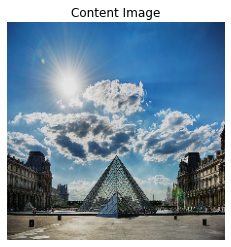

In [58]:
imshow(content_image, 'Content Image')

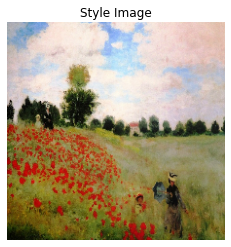

In [59]:
imshow(style_image, 'Style Image')

In [61]:
def gram_matrix(A):
  result = tf.linalg.einsum('bijc,bijd->bcd', A, A)
  input_shape = tf.shape(A)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [62]:
from tensorflow.keras.models import Model


def MyVGG16(names):
  base_model=VGG19(include_top=False, weights='imagenet')
  base_model.trainable = False
  outputs=[base_model.get_layer(name).output for name in names]
  model=Model([base_model.input], outputs=outputs)
  return model


class ArtGenerationwithNeuralStyleTransfer(tf.keras.models.Model):
  def __init__(self,ContentLayers_name,StyleLayers_name):
    super(ArtGenerationwithNeuralStyleTransfer, self).__init__()
    self.ContentLayers=ContentLayers_name
    self.StyleLayers=StyleLayers_name
    self.styleLayer_num=len(StyleLayers_name)
    self.vgg=MyVGG16(self.StyleLayers+self.ContentLayers)
    self.vgg.trainable = False

  def call(self,image):
    image = image*255.0
    PreProcess_image=preprocess_input(image)
    output=self.vgg(PreProcess_image)
    Content_output=output[self.styleLayer_num:]
    content_dic={name:value for (name,value) in zip(self.ContentLayers,Content_output)}
    StyleOutput=output[:self.styleLayer_num]
    style_gram=[gram_matrix(style_output) for style_output in StyleOutput]
    gram_dic={name:value for (name,value) in zip(self.StyleLayers,style_gram)}
    return {'content':content_dic,'style':gram_dic}



In [63]:
stm=ArtGenerationwithNeuralStyleTransfer(content_layers_names,style_layers_names)

In [64]:
target_style=stm(style_image)['style']
target_content=stm(content_image)['content']

In [65]:
a_C=[target_content[name] for name in target_content.keys()][0]
a_S_layer_output=target_style

In [66]:
def compute_content_cost(generated_image_content_output):
  a_G=[generated_image_content_output[name] for name in generated_image_content_output.keys()][0]
  m, n_H, n_W, n_C = a_G.get_shape()
  new_shape=[int(m),int(n_H*n_W),int(n_C)]
  new_a_C=tf.reshape(a_C,new_shape)
  new_a_G=tf.reshape(a_G,new_shape)
  J_content=(.25 / float(int(n_H * n_W * n_C))) * tf.reduce_sum((new_a_G - new_a_C)**2)
  return J_content


In [67]:
def compute_layer_style_cost(GS, GG):
    m, n_H_n_W, n_C = GG.get_shape()
    '''
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])
    a_G = tf.transpose(a_G)
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
'''
    factor = (.5 / (n_H_n_W * n_C)) ** 2
    J_style_layer = factor * tf.reduce_sum((GS - GG)**2)
    return J_style_layer

In [68]:
def compute_style_cost(generated_image_style_output):
  #generated_image_layer_output=[generated_image_style_output[name] for name in generated_image_style_output.keys()]

  J_style = 0
  for (name, coeff) in STYLE_LAYERS:
    a_S = a_S_layer_output[name]
    a_G = generated_image_style_output[name]
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    J_style += coeff * J_style_layer

  return J_style

In [69]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style    
    return J

In [70]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [71]:
def lose(output):
  style=output['style']
  content=output['content']
  J_content=compute_content_cost(content)
  J_style=compute_style_cost(style)
  lose=total_cost(J_content, J_style, alpha = 10, beta = 40)
  return lose

In [72]:
generated_image=tf.Variable(content_image,trainable=True)

In [73]:
import numpy as np
import PIL

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [74]:
def clip(input):
  return tf.clip_by_value(input, clip_value_min=0.0, clip_value_max=1.0)

In [111]:
@tf.function
def step_by_step(image):
  with tf.GradientTape() as tape:
    tape.watch(image)
    output=stm(image)
    los=lose(output)

    grads=tape.gradient(los,image)
    opt.apply_gradients([(grads, image)])
    image.assign(clip(image))

In [127]:
def save_img(image, name=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  plt.axis('off')
  plt.savefig(name)

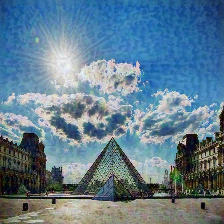

In [76]:
step_by_step(generated_image)
step_by_step(generated_image)
step_by_step(generated_image)

tensor_to_image(generated_image)

In [137]:
from IPython.display import clear_output,display


def transfer_image(style_image_path,content_image_path,epoch=30,step_per_epoch=40):
  style_image = load_img(style_image_path)
  content_image = load_img(content_image_path)

  imshow(style_image, 'style image')

  plt.figure
  imshow(content_image, 'content image')

  plt.axis('off')
  plt.figure
  
  target_style=stm(style_image)['style']
  target_content=stm(content_image)['content']

  #generated_image=tf.Variable(content_image,trainable=True)

  a_C=[target_content[name] for name in target_content.keys()][0]
  a_S_layer_output=target_style

  for i in range(epoch):
    for j in range(step_per_epoch):
      step_by_step(generated_image)
      print('the {0}th step'.format(i*epoch+j))
    clear_output(wait=True)
    display(tensor_to_image(generated_image))

  print("the training ended")
  imshow(generated_image, 'generated image')
  return generated_image


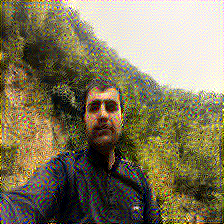

the training ended


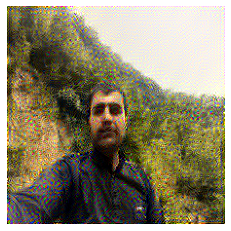

In [141]:
style_image_path='/content/Mona-Lisa.jpg'
content_image_path='/content/20160511_155956.jpg'
display(imshow(style_image, 'style image'))
image=transfer_image(style_image_path,content_image_path,epoch=1,step_per_epoch=3)

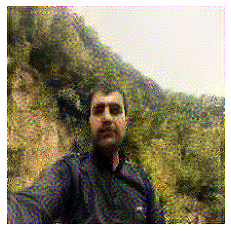

In [128]:
save_img(generated_image,'a.png')

In [142]:
style_image = load_img(style_image_path)
content_image = load_img(content_image_path)

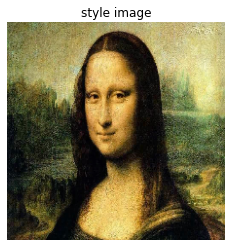

In [147]:
imshow(style_image, 'style image')

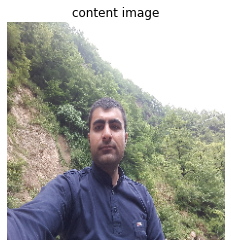

In [146]:
imshow(content_image, 'content image')